# Загрузка необходимых библиотек

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 15.2 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import zipfile
import pandas as pd
from mtcnn import MTCNN
import cv2

In [ ]:
! pip install gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Загрузка dataset - train.zip

In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1QdhIxh1QUEuLgRb7DWa7RA7CA08ybNRJ&export=download'
output = 'train.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1QdhIxh1QUEuLgRb7DWa7RA7CA08ybNRJ&export=download
To: /content/train.zip
100%|██████████| 2.27G/2.27G [00:14<00:00, 152MB/s]


'train.zip'

In [ ]:
if 1:
    !unzip /content/train.zip -d ./

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./train/uncertain/1832.jpg  
  inflating: ./train/uncertain/1833.jpg  
  inflating: ./train/uncertain/1834.jpg  
  inflating: ./train/uncertain/1835.jpg  
  inflating: ./train/uncertain/1836.jpg  
  inflating: ./train/uncertain/1837.jpg  
  inflating: ./train/uncertain/1838.jpg  
  inflating: ./train/uncertain/1839.jpg  
  inflating: ./train/uncertain/184.jpg  
  inflating: ./train/uncertain/1840.jpg  
  inflating: ./train/uncertain/1841.jpg  
  inflating: ./train/uncertain/1842.jpg  
  inflating: ./train/uncertain/1843.jpg  
  inflating: ./train/uncertain/1844.jpg  
  inflating: ./train/uncertain/1845.jpg  
  inflating: ./train/uncertain/1846.jpg  
  inflating: ./train/uncertain/1847.jpg  
  inflating: ./train/uncertain/1848.jpg  
  inflating: ./train/uncertain/1849.jpg  
  inflating: ./train/uncertain/185.jpg  
  inflating: ./train/uncertain/1850.jpg  
  inflating: ./train/uncertain/1851.jpg  
  inflatin

In [ ]:
# определим папки с данными
train_dir = Path().parent / "train"

train_anger_dir = train_dir / 'anger'
train_contempt_dir = train_dir / 'contempt'
train_disgust_dir = train_dir / 'disgust'
train_fear_dir = train_dir / 'fear'
train_happy_dir = train_dir / 'happy'
train_neutral_dir = train_dir / 'neutral'
train_sad_dir = train_dir / 'sad'
train_surprise_dir = train_dir / 'surprise'
train_uncertain_dir = train_dir / 'uncertain'

In [ ]:
num_anger_tr = len(list(train_anger_dir.glob("*"))) # .glob("*") создает итератор по всем файлам в директории
num_contempt_tr = len(list(train_contempt_dir.glob("*")))
num_disgust_tr = len(list(train_disgust_dir.glob("*")))
num_fear_tr = len(list(train_fear_dir.glob("*")))
num_happy_tr = len(list(train_happy_dir.glob("*")))
num_neutral_tr = len(list(train_neutral_dir.glob("*")))
num_sad_tr = len(list(train_sad_dir.glob("*")))
num_surprise_tr = len(list(train_surprise_dir.glob("*")))
num_uncertain_tr = len(list(train_uncertain_dir.glob("*")))

total_train = num_anger_tr + num_contempt_tr + num_disgust_tr + num_fear_tr + num_happy_tr + \
        num_neutral_tr + num_sad_tr + num_surprise_tr + num_uncertain_tr

In [ ]:
print('anger images:', num_anger_tr)
print('contempt images:', num_contempt_tr)
print('disgust images:', num_disgust_tr)
print('fear images:', num_fear_tr)
print('happy images:', num_happy_tr)
print('neutral images:', num_neutral_tr)
print('sad images:', num_sad_tr)
print('surprise images:', num_surprise_tr)
print('uncertain images:', num_uncertain_tr)
print("--")
print("Total training images:", total_train)

anger images: 7022
contempt images: 3085
disgust images: 3155
fear images: 5044
happy images: 5955
neutral images: 6795
sad images: 6740
surprise images: 6323
uncertain images: 5927
--
Total training images: 50046


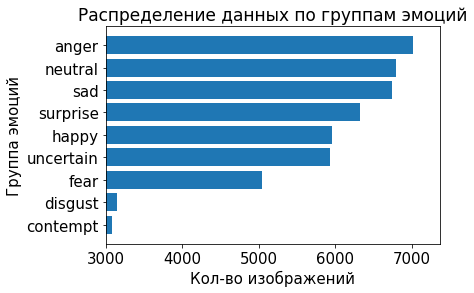

In [ ]:
name_list = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']
values_list = [num_anger_tr, num_contempt_tr, num_disgust_tr, num_fear_tr, num_happy_tr, num_neutral_tr, num_sad_tr,
               num_surprise_tr, num_uncertain_tr]
count_img_df = pd.DataFrame(values_list, index=name_list, columns=['count']).sort_values(by='count')
plt.barh(count_img_df.index, count_img_df['count'])
plt.title('Распределение данных по группам эмоций', fontsize = 17)
plt.ylabel('Группа эмоций', fontsize = 15)
plt.xlabel('Кол-во изображений', fontsize = 15)
plt.tick_params(axis = 'x', labelsize = 15, )
plt.tick_params(axis = 'y', labelsize = 15)
plt.xlim(xmin=count_img_df.min()[0] // 100 * 100)
plt.show()

###**Вывод:** Данные не сбалансированы.

Необходимо проверить наличие лиц на всех изображениях. Воспользуемся Multi-task Cascaded Convolutional Networks (MTCNN) - сверточная сеть используется для обнаружения и выравнивания лиц.

In [ ]:
detector = MTCNN()

Посмотрим как она работает на изображении с двумя лицами.

In [ ]:
img = cv2.cvtColor(cv2.imread("./train/fear/1923.jpg"), cv2.COLOR_BGR2RGB)
detector.detect_faces(img)

[{'box': [152, 66, 260, 365],
  'confidence': 0.9999803304672241,
  'keypoints': {'left_eye': (188, 211),
   'mouth_left': (196, 347),
   'mouth_right': (286, 345),
   'nose': (212, 270),
   'right_eye': (295, 207)}},
 {'box': [1, 89, 226, 279],
  'confidence': 0.9996453523635864,
  'keypoints': {'left_eye': (65, 204),
   'mouth_left': (87, 308),
   'mouth_right': (164, 304),
   'nose': (123, 249),
   'right_eye': (175, 198)}}]

Пробую сделать тоже самое, через детектор в OpenCV.

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
# иницилизируем детектор:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

--2022-07-20 02:31:03--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.02s   

2022-07-20 02:31:03 (42.7 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]



In [ ]:
img_for_cv2 = cv2.cvtColor(cv2.imread("./train/fear/1923.jpg"), cv2.COLOR_BGR2RGB)
# img_for_cv2 = cv2.cvtColor(img_for_cv2, cv2.COLOR_BGR2GRAY)  # при преобразовании в серый, тоже не сработал
faces = face_detector.detectMultiScale(img)
print("Найдено {} лицо/лиц".format(len(faces)))
print("Массив faces: {}".format(faces))

Найдено 1 лицо/лиц
Массив faces: [[ 52  62 364 364]]


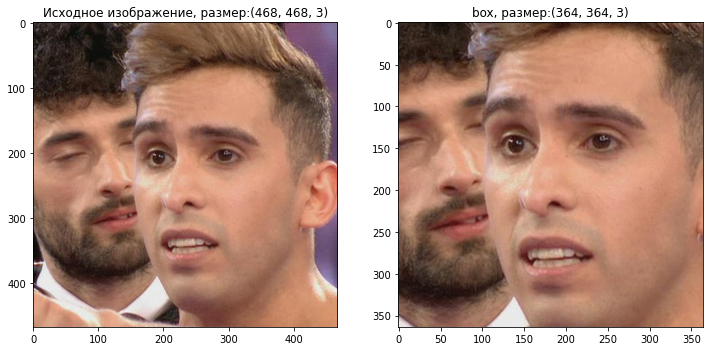

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
img_for_cv2_box = img_for_cv2[62:62+364, 52:52+364,:]
ax[0].imshow(img_for_cv2)
ax[0].set_title(f'Исходное изображение, размер:{img_for_cv2.shape}')
ax[1].imshow(img_for_cv2_box)
ax[1].set_title(f'box, размер:{img_for_cv2_box.shape}')
plt.show()

Буду использовать MTCNN() для подготовки данных. Мне важно, чтобы детектор на изображениях с 2-мя лицами и более, мог распознать все.

Text(0.5, 1.0, 'Второй box, размер:(279, 226, 3)')

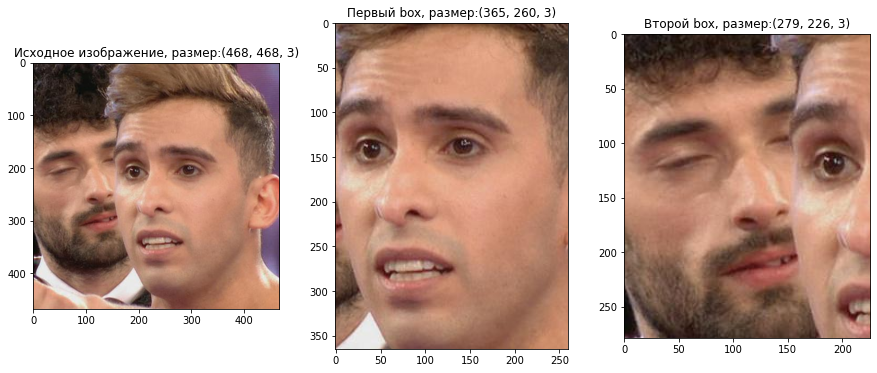

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 6))
img_new_1 = img[66:66+365, 152:152+260,:]
img_new_2 = img[89:89+279, 1:1+226,:]
ax[0].imshow(img)
ax[0].set_title(f'Исходное изображение, размер:{img.shape}')
ax[1].imshow(img_new_1)
ax[1].set_title(f'Первый box, размер:{img_new_1.shape}')
ax[2].imshow(img_new_2)
ax[2].set_title(f'Второй box, размер:{img_new_2.shape}')

Нужно распознать фотографии, где лица не детектируются - такие картинки необходимо убрать из обучающей выборки.</br>
Есть фотографии, где несколько лиц на изображении, в таком случае выберем то лицо, у которого "bounding box" занимает больше площади.

In [ ]:
img_delete = []  # создаем список изображений, где нет лица (box)
img_2face = []  # создаем список изображений, где 2 лица и более
dict_img_detect = {}  # создаем словарь, где ключ - индекс изображения, значение - выход из MTCNN
for i in range(num_anger_tr):  # проходим циклом по всем изображениям
    file_path = f"./train/anger/{i}.jpg"  # формируем путь к изображению
    img = cv2.imread(file_path)  # загружаем изображение
    img_mtcnn = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # переводим каналы RGB для MTCNN
    detect = detector.detect_faces(img_mtcnn)  # получаем выход из сети MTCNN
    dict_img_detect[i] = detect  # сохраняем выход в словарь (может и не пригодится)
    if len(detect) == 0:  # если box - не найден, зафиксируем в список
        img_delete.append(f"{i}.jpg")
    else:
        total_idx = 0  # индекс box
        if len(detect) > 1:  
            # если несколько лиц на изображении, выбираем box с наибольшей площадью - как основу
            total_square = detect[total_idx]['box'][2] * detect[total_idx]['box'][3]
            img_2face.append(f"{i}.jpg")  # добавляем имя файла в список
            for idx_box in range(1, len(detect)):
                square_box = detect[idx_box]['box'][2] * detect[idx_box]['box'][3]
                if square_box > total_square:
                    total_idx = idx_box
                    total_square = square_box
        # если один box, его индекс остается равным 0
        x_img = detect[total_idx]['box'][0]
        y_img = detect[total_idx]['box'][1]
        width_img = detect[total_idx]['box'][2]
        height_img = detect[total_idx]['box'][3]
        # вырезаем изображение по границам box
        img_new = img[y_img:y_img+height_img, x_img:x_img+width_img, :]
        cv2.imwrite(f"./redact/anger/{i}.jpg", img_new)  # сохраняем изображение

In [ ]:
dict_delete = {}
dict_2face = {}

for dir in ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']:
    direct = train_dir / dir
    count_file = len(list(direct.glob("*")))
    for i in range(count_file):  # проходим циклом по всем изображениям
        if i % 1000==0:
            print(f'{i} изображений из {count_file}')
        img_delete = []  # создаем список изображений, где нет лица (box)
        img_2face = []  # создаем список изображений, где 2 лица и более
        file_path = f"./train/{dir}/{i}.jpg"  # формируем путь к изображению
        img = cv2.imread(file_path)  # загружаем изображение
        img_mtcnn = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # переводим каналы RGB для MTCNN
        detect = detector.detect_faces(img_mtcnn)  # получаем выход из сети MTCNN
        if len(detect) == 0:  # если box - не найден, зафиксируем в список
            img_delete.append(f"{i}.jpg")
        else:
            total_idx = 0  # индекс box
            if len(detect) > 1:  
                # если несколько лиц на изображении, выбираем box с наибольшей площадью - как основу
                total_square = detect[total_idx]['box'][2] * detect[total_idx]['box'][3]
                img_2face.append(f"{i}.jpg")  # добавляем имя файла в список
                for idx_box in range(1, len(detect)):
                    square_box = detect[idx_box]['box'][2] * detect[idx_box]['box'][3]
                    if square_box > total_square:
                        total_idx = idx_box
                        total_square = square_box
            # если один box, его индекс остается равным 0
            x_img = detect[total_idx]['box'][0]
            y_img = detect[total_idx]['box'][1]
            width_img = detect[total_idx]['box'][2]
            height_img = detect[total_idx]['box'][3]
            # вырезаем изображение по границам box
            img_new = img[y_img:y_img+height_img, x_img:x_img+width_img, :]
            cv2.imwrite(f"./redact/{dir}/{i}.jpg", img_new)  # сохраняем изображение
    dict_delete[dir] = img_delete
    dict_2face[dir] = img_2face
    print(f'Закончили обработку папки: {dir}')

0 изображений из 6323
1000 изображений из 6323
2000 изображений из 6323
3000 изображений из 6323
4000 изображений из 6323
5000 изображений из 6323
6000 изображений из 6323
Закончили обработку папки: surprise
0 изображений из 5927
1000 изображений из 5927
2000 изображений из 5927
3000 изображений из 5927


In [ ]:
!zip -r redact.zip redact

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: redact/fear/4298.jpg (deflated 0%)
  adding: redact/fear/3059.jpg (deflated 1%)
  adding: redact/fear/1.jpg (deflated 0%)
  adding: redact/fear/3612.jpg (deflated 1%)
  adding: redact/fear/496.jpg (deflated 2%)
  adding: redact/fear/931.jpg (deflated 2%)
  adding: redact/fear/1787.jpg (deflated 0%)
  adding: redact/fear/2903.jpg (deflated 0%)
  adding: redact/fear/3948.jpg (deflated 0%)
  adding: redact/fear/3457.jpg (deflated 1%)
  adding: redact/fear/3472.jpg (deflated 0%)
  adding: redact/fear/2868.jpg (deflated 0%)
  adding: redact/fear/3305.jpg (deflated 0%)
  adding: redact/fear/3655.jpg (deflated 1%)
  adding: redact/fear/3380.jpg (deflated 1%)
  adding: redact/fear/1863.jpg (deflated 0%)
  adding: redact/fear/4197.jpg (deflated 1%)
  adding: redact/fear/4966.jpg (deflated 2%)
  adding: redact/fear/2054.jpg (deflated 1%)
  adding: redact/fear/2090.jpg (deflated 1%)
  adding: redact/fear/163.jpg (deflat

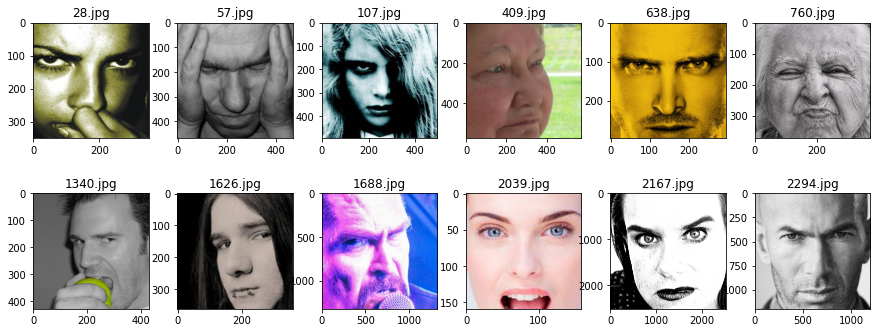

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(15, 6))
i=0
for img_dir in dict_delete['anger'][:12]:
    file_path = f"./train/anger/{img_dir}"
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    ax = axs[i//6, i%6]
    ax.imshow(img)
    ax.set_title(img_dir)
    i+=1
plt.subplots_adjust(hspace=0.1, wspace=0.25)
plt.show()

На данных изображениях лица не за детектированы. Весь объем лица не вошел в кадр или лицо чем-либо перекрыто.

In [ ]:
# определим папки с данными, теперь итоговые изображения находятся в папке redact
train_dir = Path().parent / "redact"

train_anger_dir = train_dir / 'anger'
train_contempt_dir = train_dir / 'contempt'
train_disgust_dir = train_dir / 'disgust'
train_fear_dir = train_dir / 'fear'
train_happy_dir = train_dir / 'happy'
train_neutral_dir = train_dir / 'neutral'
train_sad_dir = train_dir / 'sad'
train_surprise_dir = train_dir / 'surprise'
train_uncertain_dir = train_dir / 'uncertain'

In [ ]:
num_anger_tr = len(list(train_anger_dir.glob("*"))) # .glob("*") создает итератор по всем файлам в директории
num_contempt_tr = len(list(train_contempt_dir.glob("*")))
num_disgust_tr = len(list(train_disgust_dir.glob("*")))
num_fear_tr = len(list(train_fear_dir.glob("*")))
num_happy_tr = len(list(train_happy_dir.glob("*")))
num_neutral_tr = len(list(train_neutral_dir.glob("*")))
num_sad_tr = len(list(train_sad_dir.glob("*")))
num_surprise_tr = len(list(train_surprise_dir.glob("*")))
num_uncertain_tr = len(list(train_uncertain_dir.glob("*")))

total_train = num_anger_tr + num_contempt_tr + num_disgust_tr + num_fear_tr + num_happy_tr + \
        num_neutral_tr + num_sad_tr + num_surprise_tr + num_uncertain_tr

In [ ]:
print('anger images:', num_anger_tr)
print('contempt images:', num_contempt_tr)
print('disgust images:', num_disgust_tr)
print('fear images:', num_fear_tr)
print('happy images:', num_happy_tr)
print('neutral images:', num_neutral_tr)
print('sad images:', num_sad_tr)
print('surprise images:', num_surprise_tr)
print('uncertain images:', num_uncertain_tr)
print("--")
print("Total training images:", total_train)

anger images: 6982
contempt images: 3075
disgust images: 3139
fear images: 5003
happy images: 5930
neutral images: 6761
sad images: 6706
surprise images: 6287
uncertain images: 5885
--
Total training images: 49768


В итоге из выборки исключили **278** изображений, на которых лица не определены.</br>
По каждой из групп исключено: anger – 40; contempt – 10; disgust – 16; fear – 41; happy – 25; neutral – 34; sad – 34; surprise – 36; uncertain – 42.


Среди изображений могут быть дубликаты. Дубликаты могут находится как в одной из групп эмоций, так и попасть в разные эмоции.</br></br>
Избавимся от этих изображений следующим путем:</br>
1) Будем работать с изображениями ограниченными по "bounding box". Если исходные картинки незначительно отличались размером или смещением, обрезая лица по "bounding box" - картинки станут одинаковые, если лицо полностью попало в кадр;</br>
2) Масштабируем картинку в размер 8*8;</br>
3) Переводим цветное изображение в одноканальное (серые тона);</br>
4) Считаем среднее значение яркости. Дальше дискретизируем значения на 0 и 1. Все что выше среднего значения переводим в 1, все что ниже - 0;</br>
В результате получим готовый хеш, он не зависит от обесцвечивания и мелкого изменения пикселей, его можно использовать как индекс при группировке.</br></br>
Убедимся, что этот метод работает на нескольких примерах:</br>
Пример 1: Возьмем 2 одинаковых изображения, но разных размеров с небольшим смещением лица;</br>
Пример 2: Возьмем 2 изображения, но в одном случае лицо попадает в кадр, в другом нет (посмотрим к чему приведет).</br>

In [ ]:
def crop_box(img):
    '''Вырезаем bounding box'''
    detect = detector.detect_faces(img)
    x = detect[0]['box'][0]
    y = detect[0]['box'][1]
    width = detect[0]['box'][2]
    hight = detect[0]['box'][3]
    img_new = img[y:y+hight, x:x+width,:]
    return img_new
def show_images(img1, img2, title1, title2):
    '''Визуализируем рядом 2 изображения'''
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax[0].imshow(img1)
    ax[0].set_title(title1)
    ax[1].imshow(img2)
    ax[1].set_title(title2)
    plt.show()
def hash_image(img):
    '''Определяем хэш изображению'''
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (8, 8), interpolation = cv2. INTER_AREA)
    hash = (img > round(img.mean())).astype('int')
    # hash = (img > round(np.median(img))).astype('int')
    return hash

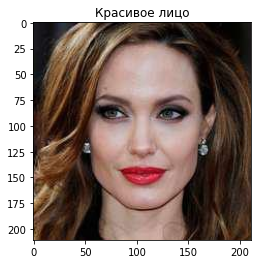

In [ ]:
img = cv2.cvtColor(cv2.imread("./train/happy/1470.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Красивое лицо')
plt.show()

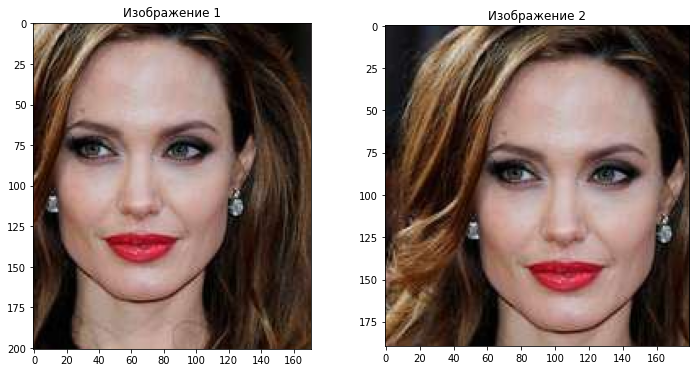

In [ ]:
img1 = img[10:, 40:, :]  # сместим лицо влево (обрезаем фон слева)
img2 = img[:190, :180, :]  # сместим лицо вправо (обрезаем фон справа)
show_images(img1, img2, 'Изображение 1', 'Изображение 2')

Теперь проверим, присвоится ли один хеш этим изображениям.

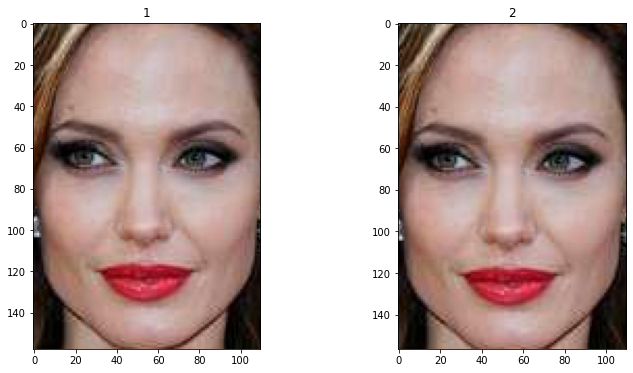

In [ ]:
img1_box = crop_box(img1)
img2_box = crop_box(img2)
show_images(img1_box, img2_box, '1', '2')
hash_img_1 = hash_image(img1_box)
hash_img_2 = hash_image(img2_box)

In [ ]:
hash_img_1==hash_img_2

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

Отлично! Все значения совпали.</br>
Рассмотрим следующий пример

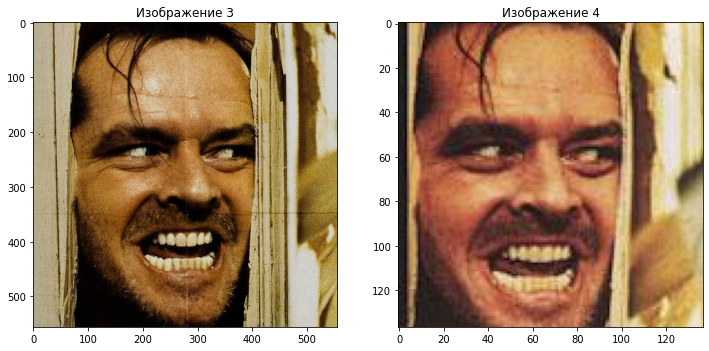

In [ ]:
img3 = cv2.cvtColor(cv2.imread("./train/anger/5528.jpg"), cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(cv2.imread("./train/anger/5828.jpg"), cv2.COLOR_BGR2RGB)
show_images(img3, img4, 'Изображение 3', 'Изображение 4')

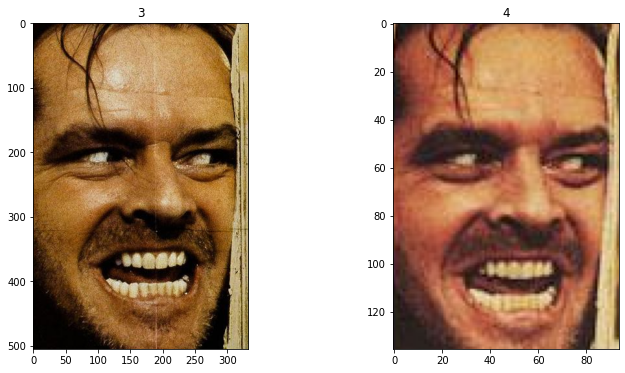

In [ ]:
img3_box = crop_box(img3)
img4_box = crop_box(img4)
show_images(img3_box, img4_box, '3', '4')
hash_img_3 = hash_image(img3_box)
hash_img_4 = hash_image(img4_box)

In [ ]:
hash_img_3 == hash_img_4

array([[ True, False,  True,  True,  True,  True, False, False],
       [ True, False,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True, False, False,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True, False,  True,  True,  True,  True,  True],
       [ True,  True, False, False, False, False,  True,  True]])

В этом случае хеш у изображений будет разный. Т.к. отличается масштаб, яркость, цвета и еще в одном случае лицо полностью входит в кадр, а в другом нет.</br>
**Вывод: Вышеприведенный алгоритм присвоения хеша для изображений, позволяет выявить дубликаты, даже если у них есть смещение, но лицо полностью должно входить в изображение.**</br>
Далее циклом пройдемся по всем изображениям и создадим DataFrame, где каждая строка будет содержать путь к файлу и присвоенный хеш файла.

In [ ]:
# преобразуем хеш в код
hash1 = "".join(map(str, hash_img_1.reshape(-1)))
hash2 = "".join(map(str, hash_img_2.reshape(-1)))
hash3 = "".join(map(str, hash_img_3.reshape(-1)))
hash4 = "".join(map(str, hash_img_4.reshape(-1)))

In [ ]:
df = pd.DataFrame([[hash1, 'путь 1'], [hash2, 'путь 2'], [hash3, 'путь 3'], [hash4, 'путь 4']], 
                  columns = ['hash', 'directory'])
df = df.groupby(['hash'], as_index=False).agg(list)
df

,hash,directory
0,0001111000111111000111110000100011111111000000...,[путь 4]
1,0011110001111110001111100001100101111111011111...,"[путь 1, путь 2]"
2,0101110101111111000111110000100111100111000000...,[путь 3]


Одинаковые изображения сгруппировались в один хеш.

Загружаем данные с googl-drive. Повторим тоже самое с входными данными, уже обрезанными по bounding box.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.listdir())

['.config', 'drive', 'double.csv', 'sample_data']


In [ ]:
# прописываем путь к архиву
zip_file = '/content/drive/MyDrive/DS_identity_emotions/input_data/redact.zip'

# распакуем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
# определим папки с данными, теперь итоговые изображения находятся в папке redact
train_dir = Path().parent / "redact"

train_anger_dir = train_dir / 'anger'
train_contempt_dir = train_dir / 'contempt'
train_disgust_dir = train_dir / 'disgust'
train_fear_dir = train_dir / 'fear'
train_happy_dir = train_dir / 'happy'
train_neutral_dir = train_dir / 'neutral'
train_sad_dir = train_dir / 'sad'
train_surprise_dir = train_dir / 'surprise'
train_uncertain_dir = train_dir / 'uncertain'

In [ ]:
double_list = []  # создаем список для сохранения пары [хеш, путь к файлу]
directory_list = [train_anger_dir, 
                  train_contempt_dir, 
                  train_disgust_dir, 
                  train_fear_dir, 
                  train_happy_dir,
                  train_neutral_dir,
                  train_sad_dir,
                  train_surprise_dir,
                  train_uncertain_dir]
for direct in directory_list:
    count_file = os.listdir(direct)  # создаем список файлов в папке
    for i in count_file:
        img_path = direct / i
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # преобразуем изображение в серые тона
        img = cv2.resize(img, (8, 8), interpolation = cv2. INTER_AREA)  # уменьшаем до размера 8*8
        hash = (img > round(img.mean())).astype('int')  # вычисляем хеш
        hash = "".join(map(str, hash.reshape(-1)))  # векторизуем хеш и преобразовываем в строку
        double_list.append([hash, img_path])

In [ ]:
df = pd.DataFrame(double_list, columns = ['hash', 'directory'])
df = df.groupby(['hash'], as_index=False).agg(list)
df['count_file'] = df['directory'].apply(lambda x: len(x))
df.sort_values(['count_file'], ascending=False, inplace=True)
df = df[df['count_file'] > 1]
df

,hash,directory,count_file
17013,0001111000111111000111110001101100011111000111...,"[redact/surprise/774.jpg, redact/surprise/5532...",12
20161,0011100001111000000110000111111011111110010001...,"[redact/fear/4199.jpg, redact/fear/2894.jpg, r...",10
28755,0011111100111111000111110001101101011111011111...,"[redact/fear/1233.jpg, redact/fear/3606.jpg, r...",10
46893,1111111110011100010010110111111101111110000000...,"[redact/sad/291.jpg, redact/sad/3691.jpg, reda...",10
1902,0000000000010000001001000111111001111111111110...,"[redact/disgust/353.jpg, redact/disgust/2907.j...",9
...,...,...,...
3017,0000000000110000010000000111110011111111111110...,"[redact/disgust/2517.jpg, redact/fear/55.jpg]",2
36853,0111111011111110011001000000010101111111001110...,"[redact/happy/4154.jpg, redact/happy/3566.jpg]",2
7018,0000000100001000000000000111111101101111110010...,"[redact/fear/3889.jpg, redact/fear/102.jpg]",2
23944,0011110001111110000110110001110101111111011001...,"[redact/sad/445.jpg, redact/sad/5340.jpg]",2


Группировка по хешу удалась, проверим визуально список дубликатов с самым большим количеством.

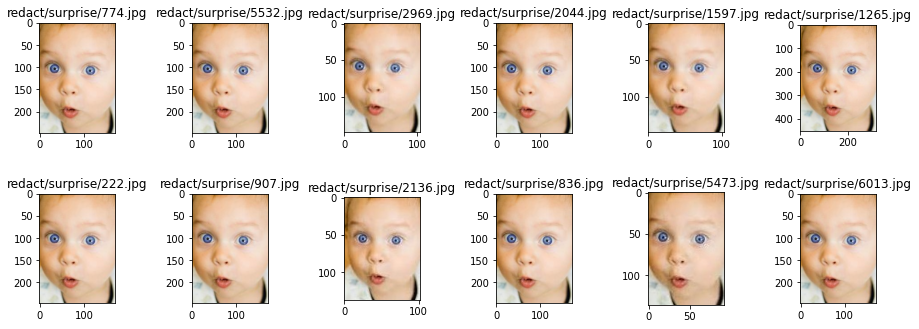

In [ ]:
file_list = df.iloc[0]['directory']
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(15, 6))
for i in range(len(file_list)):
    img = cv2.cvtColor(cv2.imread(str(file_list[i])), cv2.COLOR_BGR2RGB)
    ax = axs[i//6, i%6]
    ax.imshow(img)
    ax.set_title(str(file_list[i]))
plt.subplots_adjust(hspace=0.1, wspace=1)
plt.show()

Метод сработал! Несмотря на то, что данные изображения изначально имели разный вес и разрешения пикселей, после проведения следующего ряда операций: детектирование лица, преобразование в серые тона, уменьшение пикселей до размера 8х8 и дискретизации по среднему значению яркости - удалось сгруппировать их в один хеш.</br></br>
Дальше будем избавляться от дубликатов по следующим принципам:</br></br>
1)	*Если все дубликаты находятся в одной папке, оставляем первый – остальные удаляем.*</br>
2)	*Если хотя бы один дубликат из списка всех дубликатов попадает в другую группу эмоций – удаляем весь список дубликатов. Будем воспринимать это как неверно размеченные данные.*


In [ ]:
df.to_csv('double.csv') # сохраним файл

Загрузим файл, чтоб не проходить заново все вышележащие коды, если colab вылетит.

In [ ]:
df_double = pd.read_csv('double.csv')
df_double.head(3)

,Unnamed: 0,hash,directory,count_file
0,17013,0001111000111111000111110001101100011111000111...,"[PosixPath('redact/surprise/774.jpg'), PosixPa...",12
1,20161,0011100001111000000110000111111011111110010001...,"[PosixPath('redact/fear/4199.jpg'), PosixPath(...",10
2,28755,0011111100111111000111110001101101011111011111...,"[PosixPath('redact/fear/1233.jpg'), PosixPath(...",10


In [ ]:
df_double['directory'][0]  # посмотрим, как выглядит строка, чтоб понять как ее обработать

"[PosixPath('redact/surprise/774.jpg'), PosixPath('redact/surprise/5532.jpg'), PosixPath('redact/surprise/2969.jpg'), PosixPath('redact/surprise/2044.jpg'), PosixPath('redact/surprise/1597.jpg'), PosixPath('redact/surprise/1265.jpg'), PosixPath('redact/surprise/222.jpg'), PosixPath('redact/surprise/907.jpg'), PosixPath('redact/surprise/2136.jpg'), PosixPath('redact/surprise/836.jpg'), PosixPath('redact/surprise/5473.jpg'), PosixPath('redact/surprise/6013.jpg')]"

In [ ]:
df_double['folder_emotions'] = df_double['directory']  # будут храниться названия папок дубликатов
for i in range(df_double.shape[0]):  # идем по списку строк
    dir_list = df_double['directory'][i][1:-1].split(", ")  # убираем скобки и разделяем пути на список
    folder_list = []  # создаем список для имен папок
    for j in range(len(dir_list)):
        dir_list[j] = dir_list[j][11:-2]  # убираем ненужные символы из строки
        folder = dir_list[j].split('/')[1]  # разделяем строку пути и достаем только название папки
        folder_list.append(folder)  # добавляем папку в список
    df_double['directory'][i] = dir_list  # меняем строку на список путей к изображению в формате строки
    df_double['folder_emotions'][i] = folder_list  # меняем содержимое на список папок

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Проверим, количество папок должно соответствовать количеству файлов - 925

In [ ]:
df_double['unique_folder'] = df_double['folder_emotions'].apply(lambda x: len(x))
(df_double['unique_folder'] == df_double['count_file']).sum()

925

Добавим колонку с количеством уникальных значений папок. По ней будем ориентироваться:</br>Если > 1 - удаляем весь список дубликатов;</br>Если = 1 - оставляем первый, а остальные тоже удалим.

In [ ]:
df_double['unique_folder'] = df_double['folder_emotions'].apply(lambda x: len(set(x)))
df_double.head(3)

,Unnamed: 0,hash,directory,count_file,folder_emotions,unique_folder
0,17013,0001111000111111000111110001101100011111000111...,"[redact/surprise/774.jpg, redact/surprise/5532...",12,"[surprise, surprise, surprise, surprise, surpr...",1
1,20161,0011100001111000000110000111111011111110010001...,"[redact/fear/4199.jpg, redact/fear/2894.jpg, r...",10,"[fear, fear, fear, fear, fear, fear, fear, fea...",2
2,28755,0011111100111111000111110001101101011111011111...,"[redact/fear/1233.jpg, redact/fear/3606.jpg, r...",10,"[fear, fear, fear, fear, fear, fear, fear, sad...",3


In [ ]:
delete_img = []  # создаем список путей к файлам, которые собираемся удалить
df_double['delete'] = None  # колонка будет содержать пути к файлам, которые собираемся удалить
for i in range(df_double.shape[0]):
    if df_double['unique_folder'][i] > 1:  # если дубликаты расположены в разных папках
        delete_img.extend(df_double['directory'][i])  # удалим все
        df_double['delete'][i] = df_double['directory'][i]
    else:
        delete_img.extend(df_double['directory'][i][1:])  # если дубликаты расположены в одной папке
        df_double['delete'][i] = df_double['directory'][i][1:]  # оставим первые изображение

print(f'Мы удалим: {len(delete_img)} фотографий')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Мы удалим: 1560 фотографий


In [ ]:
for del_img in delete_img:
    os.remove(del_img)

In [ ]:
print('anger images:', num_anger_tr)
print('contempt images:', num_contempt_tr)
print('disgust images:', num_disgust_tr)
print('fear images:', num_fear_tr)
print('happy images:', num_happy_tr)
print('neutral images:', num_neutral_tr)
print('sad images:', num_sad_tr)
print('surprise images:', num_surprise_tr)
print('uncertain images:', num_uncertain_tr)
print("--")
print("Total training images:", total_train)

anger images: 6746
contempt images: 3021
disgust images: 2965
fear images: 4632
happy images: 5881
neutral images: 6682
sad images: 6450
surprise images: 6089
uncertain images: 5742
--
Total training images: 48208


In [ ]:
df_total_img = pd.DataFrame([["anger", 7022, 6982, 6746],
                             ["contempt", 3085, 3075, 3021],
                             ["disgust", 3155, 3139, 2965],
                             ["fear", 5044, 5003, 4632],
                             ["happy", 5955, 5930, 5881],
                             ["neutral", 6795, 6761, 6682],
                             ["sad", 6740, 6706, 6450],
                             ["surprise", 6323, 6287, 6089],
                             ["uncertain", 5927, 5885, 5742],
                             ["Total", 50046, 49768, 48208]],
                            columns = ['folder', 'count_input', 'count_filt_face', 'count_filt_double'])
df_total_img['not_face'] = df_total_img['count_input'] - df_total_img['count_filt_face']
df_total_img['double'] = df_total_img['count_filt_face'] - df_total_img['count_filt_double']
df_total_img['delete_img'] = df_total_img['not_face'] + df_total_img['double']
df_total_img['delete_%'] = round((df_total_img['delete_img'] / df_total_img['count_input']) * 100, 1)
df_total_img

,folder,count_input,count_filt_face,count_filt_double,not_face,double,delete_img,delete_%
0,anger,7022,6982,6746,40,236,276,3.9
1,contempt,3085,3075,3021,10,54,64,2.1
2,disgust,3155,3139,2965,16,174,190,6.0
3,fear,5044,5003,4632,41,371,412,8.2
4,happy,5955,5930,5881,25,49,74,1.2
5,neutral,6795,6761,6682,34,79,113,1.7
6,sad,6740,6706,6450,34,256,290,4.3
7,surprise,6323,6287,6089,36,198,234,3.7
8,uncertain,5927,5885,5742,42,143,185,3.1
9,Total,50046,49768,48208,278,1560,1838,3.7


In [ ]:
!zip -r redact_clean.zip redact

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: redact/uncertain/498.jpg (deflated 1%)
  adding: redact/uncertain/4740.jpg (deflated 1%)
  adding: redact/uncertain/5356.jpg (deflated 1%)
  adding: redact/uncertain/3047.jpg (deflated 2%)
  adding: redact/uncertain/4413.jpg (deflated 0%)
  adding: redact/uncertain/2100.jpg (deflated 1%)
  adding: redact/uncertain/5508.jpg (deflated 1%)
  adding: redact/uncertain/2878.jpg (deflated 1%)
  adding: redact/uncertain/1058.jpg (deflated 2%)
  adding: redact/uncertain/627.jpg (deflated 1%)
  adding: redact/uncertain/5645.jpg (deflated 2%)
  adding: redact/uncertain/361.jpg (deflated 0%)
  adding: redact/uncertain/4032.jpg (deflated 0%)
  adding: redact/uncertain/73.jpg (deflated 1%)
  adding: redact/uncertain/258.jpg (deflated 1%)
  adding: redact/uncertain/4264.jpg (deflated 0%)
  adding: redact/uncertain/1443.jpg (deflated 1%)
  adding: redact/uncertain/1804.jpg (deflated 1%)
  adding: redact/uncertain/3233.jpg (d

#**Вывод по анализу данных:**</br>
Удалено 3.7 % изображений. Можно переходить к следующему этапу: «Аугментация». Т.к. данные не сбалансированы. На шаге анализа данных было сделано следующее:</br></br>
1)	Обрезали все изображения по bounding box – это сделано, т.к. в дальнейшем сеть будет обучаться на лицах, чтобы задействовать в обучении распознавания эмоций меньше фона;</br>
2)	На изображениях с несколькими лицами, было выбрано то, которое занимает больше площади на картинке;</br>
3)	Удалены изображения, где лиц не было определено;</br>
4)	Удалены дубликаты изображений. Удалось даже распознать дубликаты, если файлы имели разный вес и размер изображений.</br>
    *4.1) Если дубликаты находились в одной папке, первое изображение оставалось, а последующие дубликаты были удалены;</br>
    4.2) Если дубликаты были расположены в разных папках – удалялись все дубликаты данного изображения вместе с ним.*
